In [1]:
# !pip install tiktoken

In [2]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import tiktoken

batch_size = 128
max_len = 256
d_model = 512
n_layers = 6
n_heads = 8
ffn_hidden = 2048
drop_prob = 0.1
init_lr = 0.1
factor = 0.9
patience = 10
warmup = 100
adam_eps = 5e-9
epoch = 1000
clip = 1
weight_decay = 5e-4

In [3]:
l = os.listdir("harry")
data = ""
for i in l:
    with open("harry/"+i, 'r') as f:
        data += f.read()
data[:1000]

'M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.\n\nMr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere.\n\nThe Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn’t think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Dursley’s sister, but they hadn’t met for sever

In [4]:
# enc = tiktoken.get_encoding("o200k_base")
# assert enc.decode(enc.encode("hello world")) == "hello world"

# # To get the tokeniser corresponding to a specific model in the OpenAI API:
# enc = tiktoken.encoding_for_model("gpt-4o")

In [5]:
# test =enc.encode("hello world my name is Gautam Gupta")

In [6]:
# test

In [7]:
# VOCAB_SIZE = enc.n_vocab
# d_k = 512
# sentence_length = 32

In [8]:
# class Embedding(nn.Module):
#     def __init__(self, vocab_size, d_model=d_k):
#         super().__init__()
#         self.vocab_size = vocab_size
#         self.d_model = d_model
#         self.embedding = nn.Embedding(self.vocab_size, self.d_model)
#     def forward(self, x):
#         embed = self.embedding(x)
#         return embed * np.sqrt(self.d_model)

In [9]:
# class PositionalEmbedding(nn.Module):
#     def __init__(self, d_model=d_k, max_len=sentence_length):
#         super().__init__()
#         self.d_model = d_model
#         self.max_len = max_len
#         even_i = torch.arange(0, self.d_model, 2).float()
#         # odd_i = torch.arange(1, self.d_model, 2).float()
#         denominator = torch.pow(10000, even_i / self.d_model)
#         pos = torch.arange(self.max_len).reshape(self.max_len, 1).float()
#         even_PE = torch.sin(pos / denominator)
#         odd_PE = torch.cos(pos / denominator) 
#         stack = torch.stack([even_PE, odd_PE], dim=2)
#         PE = torch.flatten(stack, start_dim=1, end_dim=2)
#         self.PE = PE

#     def forward(self , embed):
#         return self.PE + embed
#         # return PE

In [10]:
class PositionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """

    def __init__(self, d_model, max_len, device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]


class TokenEmbedding(nn.Embedding):
    """
    Token Embedding using torch.nn
    they will dense representation of word using weighted matrix
    """

    def __init__(self, vocab_size, d_model):
        """
        class for token embedding that included positional information

        :param vocab_size: size of vocabulary
        :param d_model: dimensions of model
        """
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)


class TransformerEmbedding(nn.Module):
    """
    token embedding + positional encoding (sinusoid)
    positional encoding can give positional information to network
    """

    def __init__(self, vocab_size, d_model, max_len, drop_prob, device):
        """
        class for word embedding that included positional information

        :param vocab_size: size of vocabulary
        :param d_model: dimensions of model
        """
        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_len, device)
        self.drop_out = nn.Dropout(p=drop_prob)

    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)
        return self.drop_out(tok_emb + pos_emb)

In [11]:
# em = Embedding(VOCAB_SIZE)
# embed = em.forward(test_sen) 
# embed.shape
# pe = PositionalEmbedding()
# test_embed = pe.forward(embed)

In [12]:
# test_embed

In [13]:
# nn.Embedding(VOCAB_SIZE, d_k)(torch.tensor([1, 2, 3, 4, 5]))

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=d_model, heads=8):
        super().__init__()
        self.d_model = d_model
        self.heads = heads
        self.attention = nn.ScalarDotProduct(self.d_model, self.heads)
        self.w_q = nn.Linear(self.d_model, self.d_model)
        self.w_k = nn.Linear(self.d_model, self.d_model)
        self.w_v = nn.Linear(self.d_model, self.d_model)
        self.w_concat = nn.Linear(self.d_model, self.d_model)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)
        q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v)

        out, attention = self.attention(q, k, v, mask=mask)
        out = self.concat_heads(out)
        out = self.w_concat(out)

        return out
    
    def split_heads(self, x):
        x = x.view(x.size(0), x.size(1), self.heads, self.d_model // self.heads)
        return x.permute(0, 2, 1, 3)

    def concat_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        return x.view(x.size(0), x.size(1), self.heads * (self.d_model // self.heads))

class ScalarDotProduct(nn.Module):
    def __init__(self):
        super(ScalarDotProduct, self).__init__()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None):
        batch_size, head, length, d_tensor = k.size()        
        k_T = k.transpose(-2, -1)
        factor = np.pow(d_tensor, 0.5) 
        dot_product = torch.matmul(q, k_T) / factor 
        if mask is not None:
            dot_product = dot_product.masked_fill(mask == 0, -1e9)
        
        attention = self.softmax(dot_product)
        out = torch.matmul(attention, v)

        return out, attention

In [15]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # '-1' means last dimension. 

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out    

In [16]:
class FeedForward(nn.Module):
    def __init__(self, d_model=d_model, d_ff=2048, drop_prob=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout = nn.Dropout(drop_prob)
        self.linear1 = nn.Linear(self.d_model, self.d_ff)
        self.linear2 = nn.Linear(self.d_ff, self.d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=d_model, heads=8, d_ff=2048, drop_prob=0.1):
        super().__init__()
        self.d_model = d_model
        self.heads = heads
        self.norm1 = LayerNorm(d_model=d_model)
        self.norm2 = LayerNorm(d_model=d_model)

        self.dropout1 = nn.Dropout(drop_prob)
        self.dropout2 = nn.Dropout(drop_prob)

        self.ff1 = FeedForward(d_model=d_model, d_ff=d_ff, drop_prob=drop_prob)
        # self.ff2 = FeedForward(d_model=d_model, d_ff=d_ff, drop_prob=drop_prob)

        self.attention = MultiHeadAttention(d_model=d_model, heads=heads)

        def forward(self, x, src_mask):
            _x = x
            x = self.attention(x, x, x, mask=src_mask)

            x = self.dropout1(x)
            x = self.norm1(x + _x)

            _x = x

            x = self.ff1(x)
            x = self.dropout2(x)
            x = self.norm2(x + _x)

            return x


In [18]:
class Encoder(nn.Module):
    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=enc_voc_size,
                                        drop_prob=drop_prob,
                                        device=device)

        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

    def forward(self, x, src_mask):
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, src_mask)

        return x

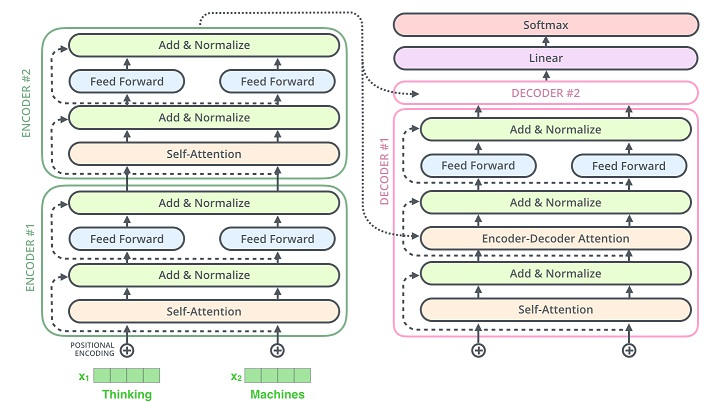

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=d_model, heads=8, d_ff=2048, drop_prob=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, heads=heads)
        self.norm1 = LayerNorm(d_model=d_model)
        self.norm2 = LayerNorm(d_model=d_model)
        self.norm3 = LayerNorm(d_model=d_model)
        self.ff = FeedForward(d_model=d_model, d_ff=d_ff, drop_prob=drop_prob)
        self.dropout1 = nn.Dropout(drop_prob)
        self.dropout2 = nn.Dropout(drop_prob)
        self.dropout3 = nn.Dropout(drop_prob)
        self.encoder_attention = MultiHeadAttention(d_model=d_model, heads=heads)

    def forward(self, dec, enc, trg_mask, src_mask):
        # _dec = dec
        # dec = self.attention(dec, dec, dec, mask=trg_mask)
        # dec = self.dropout1(dec)
        # dec = self.norm1(dec + _dec)
        # _dec = dec
        # dec = self.encoder_attention(dec, enc, enc, mask=src_mask)
        # dec = self.dropout2(dec)
        # dec = self.norm2(dec + _dec)
        # _dec = dec
        # dec = self.ff(dec)
        # dec = self.dropout3(dec)
        # dec = self.norm3(dec + _dec)
        # return dec
        _x = dec
        x = self.attention(q=dec, k=dec, v=dec, mask=trg_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        if enc is not None:
            # 3. compute encoder - decoder attention
            _x = x
            x = self.encoder_attention(q=x, k=enc, v=enc, mask=src_mask)
            
            # 4. add and norm
            x = self.dropout2(x)
            x = self.norm2(x + _x)

        # 5. positionwise feed forward network
        _x = x
        x = self.ffn(x)
        
        # 6. add and norm
        x = self.dropout3(x)
        x = self.norm3(x + _x)
        return x
        

In [20]:
class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=dec_voc_size,
                                        drop_prob=drop_prob,
                                        device=device)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, dec_voc_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, enc, trg_mask, src_mask):
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, enc, trg_mask, src_mask)

        x = self.linear(x)
        x = self.softmax(x)

        return x

In [ ]:
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    enc_voc_size = 10000
    dec_voc_size = 10000
    max_len = 256
    d_model = 512
    ffn_hidden = 2048
    n_head = 8
    n_layers = 6
    drop_prob = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder = Encoder(enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device).to(device)
    decoder = Decoder(dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device).to(device)

    # criterion = nn.CrossEntropyLoss()
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=init_lr, eps=adam_eps, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True, eps=1e-9)

    for i in range(epoch):
        for j in range(0, len(data), batch_size):
            src = data[j:j+batch_size]
            trg = data[j+1:j+batch_size+1]

            src = torch.tensor(enc.encode(src)).to(device)
            trg = torch.tensor(enc.encode(trg)).to(device)

            src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
            trg_mask = (trg != 0).unsqueeze(1).unsqueeze(2)

            enc_output = encoder(src, src_mask)
            dec_output = decoder(trg, enc_output, trg_mask, src_mask)

            optimizer.zero_grad()
            loss = criterion(dec_output, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), clip)
            optimizer.step()

            if j % 100 == 0:
                print(f"Epoch: {i}, Loss: {loss.item()}")
        scheduler.step(loss)

In [25]:
class Transformer(nn.Module):

    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, enc_voc_size, dec_voc_size, d_model, n_head, max_len,
                 ffn_hidden, n_layers, drop_prob, device):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        self.encoder = Encoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               enc_voc_size=enc_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

        self.decoder = Decoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               dec_voc_size=dec_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor).to(self.device)
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

In [27]:
import math
from collections import Counter

import numpy as np


def bleu_stats(hypothesis, reference):
    """Compute statistics for BLEU."""
    stats = []
    stats.append(len(hypothesis))
    stats.append(len(reference))
    for n in range(1, 5):
        s_ngrams = Counter(
            [tuple(hypothesis[i:i + n]) for i in range(len(hypothesis) + 1 - n)]
        )
        r_ngrams = Counter(
            [tuple(reference[i:i + n]) for i in range(len(reference) + 1 - n)]
        )

        stats.append(max([sum((s_ngrams & r_ngrams).values()), 0]))
        stats.append(max([len(hypothesis) + 1 - n, 0]))
    return stats


def bleu(stats):
    """Compute BLEU given n-gram statistics."""
    if len(list(filter(lambda x: x == 0, stats))) > 0:
        return 0
    (c, r) = stats[:2]
    log_bleu_prec = sum(
        [math.log(float(x) / y) for x, y in zip(stats[2::2], stats[3::2])]
    ) / 4.
    return math.exp(min([0, 1 - float(r) / c]) + log_bleu_prec)


def get_bleu(hypotheses, reference):
    """Get validation BLEU score for dev set."""
    stats = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for hyp, ref in zip(hypotheses, reference):
        stats += np.array(bleu_stats(hyp, ref))
    return 100 * bleu(stats)


def idx_to_word(x, vocab):
    words = []
    for i in x:
        word = vocab.itos[i]
        if '<' not in word:
            words.append(word)
    words = " ".join(words)
    return words

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


class Tokenizer:

    def __init__(self):
        self.spacy_de = spacy.load('de_core_news_sm')
        self.spacy_en = spacy.load('en_core_web_sm')

    def tokenize_de(self, text):
        """
        Tokenizes German text from a string into a list of strings
        """
        return [tok.text for tok in self.spacy_de.tokenizer(text)]

    def tokenize_en(self, text):
        """
        Tokenizes English text from a string into a list of strings
        """
        return [tok.text for tok in self.spacy_en.tokenizer(text)]

In [29]:
"""
@author : Hyunwoong
@when : 2019-10-22
@homepage : https://github.com/gusdnd852
"""
import math
import time

from torch import nn, optim
from torch.optim import Adam

# from models.model.transformer import Transformer
# from util.bleu import idx_to_word, get_bleu
# from util.epoch_timer import epoch_time
src_pad_idx = loader.source.vocab.stoi['<pad>']
trg_pad_idx = loader.target.vocab.stoi['<pad>']
trg_sos_idx = loader.target.vocab.stoi['<sos>']

enc_voc_size = len(loader.source.vocab)
dec_voc_size = len(loader.target.vocab)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)


model = Transformer(src_pad_idx=src_pad_idx,
                    trg_pad_idx=trg_pad_idx,
                    trg_sos_idx=trg_sos_idx,
                    d_model=d_model,
                    enc_voc_size=enc_voc_size,
                    dec_voc_size=dec_voc_size,
                    max_len=max_len,
                    ffn_hidden=ffn_hidden,
                    n_head=n_heads,
                    n_layers=n_layers,
                    drop_prob=drop_prob,
                    device=device).to(device)

print(f'The model has {count_parameters(model):,} trainable parameters')
model.apply(initialize_weights)
optimizer = Adam(params=model.parameters(),
                 lr=init_lr,
                 weight_decay=weight_decay,
                 eps=adam_eps)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 verbose=True,
                                                 factor=factor,
                                                 patience=patience)

criterion = nn.CrossEntropyLoss(ignore_index=src_pad_idx)


def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output_reshape, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        print('step :', round((i / len(iterator)) * 100, 2), '% , loss :', loss.item())

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    batch_bleu = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            output = model(src, trg[:, :-1])
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output_reshape, trg)
            epoch_loss += loss.item()

            total_bleu = []
            for j in range(batch_size):
                try:
                    trg_words = idx_to_word(batch.trg[j], loader.target.vocab)
                    output_words = output[j].max(dim=1)[1]
                    output_words = idx_to_word(output_words, loader.target.vocab)
                    bleu = get_bleu(hypotheses=output_words.split(), reference=trg_words.split())
                    total_bleu.append(bleu)
                except:
                    pass

            total_bleu = sum(total_bleu) / len(total_bleu)
            batch_bleu.append(total_bleu)

    batch_bleu = sum(batch_bleu) / len(batch_bleu)
    return epoch_loss / len(iterator), batch_bleu


def run(total_epoch, best_loss):
    train_losses, test_losses, bleus = [], [], []
    for step in range(total_epoch):
        start_time = time.time()
        train_loss = train(model, train_iter, optimizer, criterion, clip)
        valid_loss, bleu = evaluate(model, valid_iter, criterion)
        end_time = time.time()

        if step > warmup:
            scheduler.step(valid_loss)

        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        bleus.append(bleu)
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), 'saved/model-{0}.pt'.format(valid_loss))

        f = open('result/train_loss.txt', 'w')
        f.write(str(train_losses))
        f.close()

        f = open('result/bleu.txt', 'w')
        f.write(str(bleus))
        f.close()

        f = open('result/test_loss.txt', 'w')
        f.write(str(test_losses))
        f.close()

        print(f'Epoch: {step + 1} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tVal Loss: {valid_loss:.3f} |  Val PPL: {math.exp(valid_loss):7.3f}')
        print(f'\tBLEU Score: {bleu:.3f}')


if __name__ == '__main__':
    run(total_epoch=epoch, best_loss=inf)

NameError: name 'src_pad_idx' is not defined